# Analysis of Delivery Data
The provided data has a month’s worth of sample delivery data. The data is for 4 sales region and granularity is at order level where we get information about who is the driver, which restaurant it is ordered from and who is consumer (just the IDs and no other attributes), order’s total amount and any
discount or refund on that order.

## Data Load

In [70]:
#Loading libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pytz import timezone
import pytz
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

df = pd.read_csv("sampledata.csv")

## **Data Wrangling and Assessment**

In [71]:
df.head(1)

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Is New,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0


In [72]:
#changing column names to lower case and separate by '_'
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
df.head(1)

,customer_placed_order_datetime,placed_order_with_restaurant_datetime,driver_at_restaurant_datetime,delivered_to_consumer_datetime,driver_id,restaurant_id,consumer_id,is_new,delivery_region,is_asap,order_total,amount_of_discount,amount_of_tip,refunded_amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 14 columns):
customer_placed_order_datetime           18078 non-null object
placed_order_with_restaurant_datetime    18038 non-null object
driver_at_restaurant_datetime            13547 non-null object
delivered_to_consumer_datetime           18078 non-null object
driver_id                                18078 non-null int64
restaurant_id                            18078 non-null int64
consumer_id                              18078 non-null int64
is_new                                   18078 non-null bool
delivery_region                          18078 non-null object
is_asap                                  18078 non-null bool
order_total                              18078 non-null float64
amount_of_discount                       18078 non-null float64
amount_of_tip                            18078 non-null float64
refunded_amount                          18078 non-null float64
dtypes: bool

In [74]:
#dropping records with no datetime information for order placed at restaurant and driver at restaurant datetime. 
#This gives us 13524 records for our analysis
newdf = df.dropna(subset=['driver_at_restaurant_datetime','placed_order_with_restaurant_datetime'])

In [75]:
newdf.shape

(13524, 14)

In [76]:
newdf.describe()

,driver_id,restaurant_id,consumer_id,order_total,amount_of_discount,amount_of_tip,refunded_amount
count,13524.000000,13524.000000,13524.000000,13524.000000,13524.000000,13524.000000,13524.000000
mean,223.711846,106.862245,30560.502736,50.992709,1.356401,3.506427,0.562210
std,104.646973,98.146805,39460.683144,44.776069,6.332503,3.708116,5.938201
min,7.000000,2.000000,5.000000,3.210000,0.000000,0.000000,0.000000
25%,144.000000,20.000000,4115.000000,26.660000,0.000000,1.410000,0.000000
50%,228.000000,76.000000,10703.000000,38.700000,0.000000,2.580000,0.000000
75%,314.000000,183.000000,55126.250000,58.090000,0.000000,4.480000,0.000000
max,438.000000,409.000000,200449.000000,884.180000,162.890000,120.300000,414.770000


**Observation**: The mean order total is 51 dollars with a mean of 3.5 dollars tip, which shows on an average the drivers get around 6.8% tip per order.

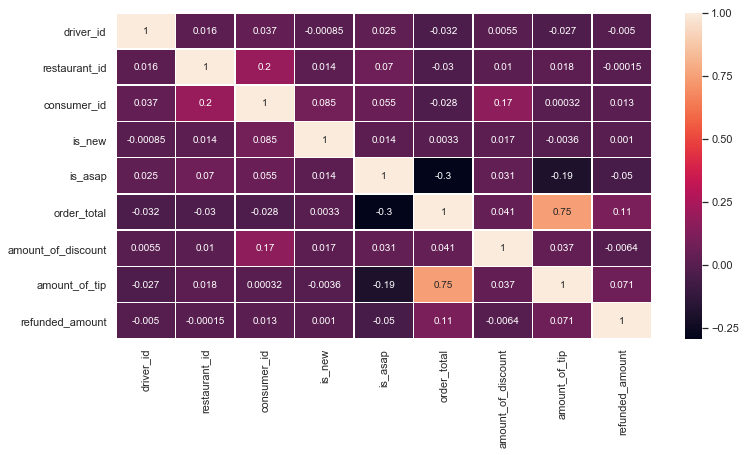

In [77]:
#Finding correlation among different data points using a heat map
corr = newdf.corr()
plt.figure(figsize = (12,6))
sns.heatmap(corr, annot=True, linewidths=0.5);

**Observation :** Above heat map shows that amount of tip is definilty positively correlated with order total, which indicates that consumers are tipping the drivers a percentage of order total and not just a fixed amount.

#### Converting from UTC to PST 

In [78]:
newdf['customer_placed_order_day'] = newdf['customer_placed_order_datetime'].apply(lambda x: x.split(" ")[0]);
newdf['customer_placed_order_time'] = newdf['customer_placed_order_datetime'].apply(lambda x: x.split(" ")[1]);

newdf['placed_order_with_restaurant_day'] = newdf['placed_order_with_restaurant_datetime'].apply(lambda x: x.split(" ")[0]);
newdf['placed_order_with_restaurant_time'] = newdf['placed_order_with_restaurant_datetime'].apply(lambda x: x.split(" ")[1]);

newdf['driver_at_restaurant_day'] = newdf['driver_at_restaurant_datetime'].apply(lambda x: x.split(" ")[0]);
newdf['driver_at_restaurant_time'] = newdf['driver_at_restaurant_datetime'].apply(lambda x: x.split(" ")[1]);

newdf['delivered_to_consumer_day'] = newdf['delivered_to_consumer_datetime'].apply(lambda x: x.split(" ")[0]);
newdf['delivered_to_consumer_time'] = newdf['delivered_to_consumer_datetime'].apply(lambda x: x.split(" ")[1]);

In [79]:

newdf['placed_order_with_restaurant_temp'] = '03-'+newdf['placed_order_with_restaurant_day'].astype(str) + '-2016'

newdf['driver_at_restaurant_temp'] = '03-'+newdf['driver_at_restaurant_day'].astype(str) + '-2016'

newdf['customer_placed_order_temp'] = '03-'+newdf['customer_placed_order_day'].astype(str) + '-2016'

newdf['delivered_to_consumer_temp'] = '03-'+newdf['delivered_to_consumer_day'].astype(str) + '-2016'

In [80]:
newdf['placed_order_with_restaurant_temp'].head()

0    03-14-2016
1    03-07-2016
2    03-13-2016
3    03-22-2016
4    03-03-2016
Name: placed_order_with_restaurant_temp, dtype: object

In [81]:
newdf['placed_order_with_restaurant_utc'] = pd.to_datetime(newdf['placed_order_with_restaurant_temp'] +' '+ newdf['placed_order_with_restaurant_time'])

newdf['driver_at_restaurant_utc'] = pd.to_datetime(newdf['driver_at_restaurant_temp'] +' '+ newdf['driver_at_restaurant_time'])

newdf['customer_placed_order_utc'] = pd.to_datetime(newdf['customer_placed_order_temp'] +' '+ newdf['customer_placed_order_time'])

newdf['delivered_to_consumer_utc'] = pd.to_datetime(newdf['delivered_to_consumer_temp'] +' '+ newdf['delivered_to_consumer_time'])

In [83]:
newdf['placed_order_with_restaurant_pst'] = newdf['placed_order_with_restaurant_utc'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

newdf['driver_at_restaurant_pst'] = newdf['driver_at_restaurant_utc'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

newdf['customer_placed_order_pst'] = newdf['customer_placed_order_utc'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

newdf['delivered_to_consumer_pst'] = newdf['delivered_to_consumer_utc'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

## Analysis

### Regions where the service is most popular based on number of orders and order amount

In [85]:
#order total by region
regions_sales = newdf.groupby('delivery_region',as_index=False).agg({'order_total':{'total_amount':'sum','order_count':'count'}})

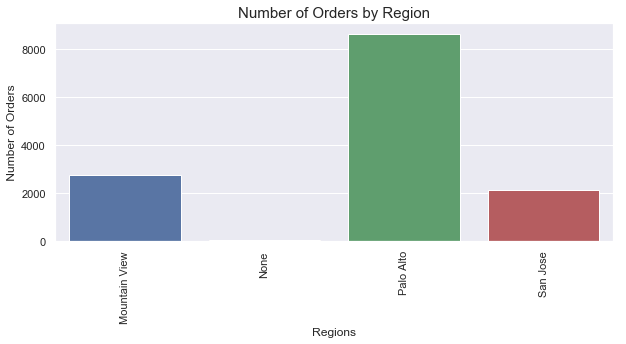

In [86]:
sns.set(style="darkgrid")
a4_dims=(10,4)
fig, ax = plt.subplots(figsize=a4_dims)
gr = sns.barplot(x="delivery_region",y=('order_total','order_count'),data=regions_sales)
gr.set_xticklabels(ax.get_xticklabels(),rotation=90);
gr.set_title("Number of Orders by Region",fontsize=15);
ax.set(ylabel=' Number of Orders ', xlabel='Regions');


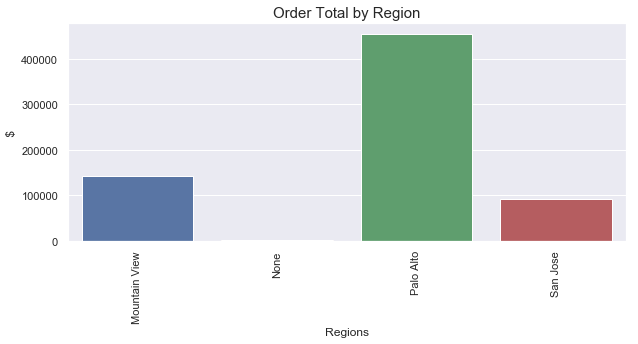

In [87]:
#orders by region
sns.set(style="darkgrid")
a4_dims=(10,4)
fig, ax = plt.subplots(figsize=a4_dims)
gr = sns.barplot(x="delivery_region",y=('order_total','total_amount'),data=regions_sales)
gr.set_xticklabels(ax.get_xticklabels(),rotation=90);
gr.set_title("Order Total by Region",fontsize=15);
ax.set(ylabel=' $ ', xlabel='Regions');

**Observation:** Palo Alto has the highest number of orders followed by Mountain View and San Jose. This shows that the service  is most popular in palo alto region but needs more awareness in the nearby areas. We will dig deeper to understand what is driving the orders in Palo Alto vs other regions

### Calculating Metrics - Prep Time, Delivery Time

>**Prep Time** and **Delivery Time** - 

In [88]:
#Prep Time - Time between order placed at restaurant and driver arriving at the restaurant to pick. The definition is assuming that the driver arrives when the food is ready
newdf['prep_time'] = newdf['driver_at_restaurant_pst']-newdf['placed_order_with_restaurant_pst']

In [89]:
#Delivery Time - The difference between the time driver arrived at the restaurant and the time the food was delivered to the consumers
newdf['delivery_time'] = newdf['delivered_to_consumer_pst']-newdf['driver_at_restaurant_pst']

In [90]:
#Converting to mins
newdf['prep_time'] = newdf['prep_time'].astype('timedelta64[m]')
newdf['delivery_time'] = newdf['delivery_time'].astype('timedelta64[m]')

In [91]:
#Dropping the records where the prep time is negative due to the conversion from UTC to PST
newdf.drop(newdf[newdf['prep_time']<(-5)].index,inplace=True)

In [92]:
newdf.drop(newdf[newdf['delivery_time']<(-5)].index,inplace=True)

In [93]:
avgdf = newdf.groupby('delivery_region',as_index=False).agg({'prep_time':'mean','delivery_time':'mean'})
avgdf.drop(avgdf[avgdf['delivery_region']=='None'].index,inplace=True)
avgdf

,delivery_region,prep_time,delivery_time
0,Mountain View,33.547810,22.575547
2,Palo Alto,18.775244,23.792462
3,San Jose,17.352717,24.348904


In [94]:
avgdf=avgdf.melt(id_vars="delivery_region", var_name="metric", value_name="avg_time",)

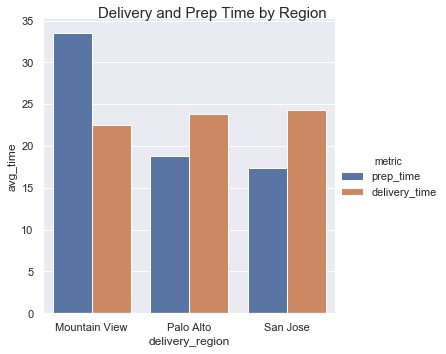

In [95]:
sns.set(style="darkgrid")
a4_dims=(12,4)
gr=sns.factorplot(x='delivery_region', y='avg_time', hue='metric', data=avgdf, kind='bar');
gr.fig.suptitle("Delivery and Prep Time by Region",fontsize=15);

In [96]:
driver_count = newdf.groupby('delivery_region')['driver_id'].nunique().reset_index()
pd.DataFrame(driver_count)

,delivery_region,driver_id
0,Mountain View,120
1,None,8
2,Palo Alto,226
3,San Jose,85


In [97]:
#counting the number of orders in each region
order_count = newdf.groupby(['delivery_region'])['driver_id'].count().reset_index()
pd.DataFrame(order_count)

,delivery_region,driver_id
0,Mountain View,2740
1,None,15
2,Palo Alto,8596
3,San Jose,2098


In [98]:
#merging data frames
ratio_df=driver_count.merge(order_count,on='delivery_region')

In [99]:
#calculating avg orders per driver in each region
ratio_df['avg_order'] = ratio_df['driver_id_y']/ratio_df['driver_id_x']
ratio_df

,delivery_region,driver_id_x,driver_id_y,avg_order
0,Mountain View,120,2740,22.833333
1,None,8,15,1.875000
2,Palo Alto,226,8596,38.035398
3,San Jose,85,2098,24.682353


### Which is the most ordered meal of the day

In [104]:
newdf['placed_order_with_restaurant_hour'] = newdf['placed_order_with_restaurant_pst'].apply(lambda x: x.hour);
newdf['placed_order_with_restaurant_hour'] = newdf['placed_order_with_restaurant_hour'].astype(int)

In [106]:
#creating Breakfast, Lunch & Dinner buckets based on the hour of the day

def func(x):
    if 3 < x <= 9:
        return 'Breakfast'
    elif 9 < x <= 16:
        return 'Lunch'
    return 'Dinner'

newdf['meal_of_the_day'] = newdf['placed_order_with_restaurant_hour'].apply(func)

In [107]:
sales_by_meal = newdf.groupby(['delivery_region','meal_of_the_day']).size().reset_index(name='counts')

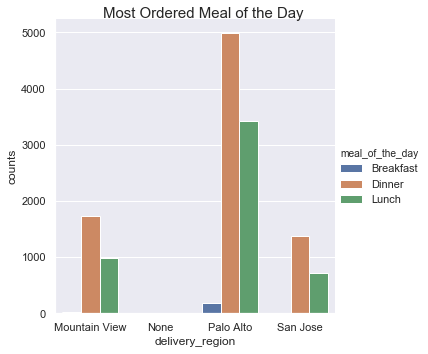

In [111]:
sns.set(style="darkgrid")
a4_dims=(12,4)
gr=sns.factorplot(x='delivery_region', y='counts', hue='meal_of_the_day', data=sales_by_meal, kind='bar');
gr.fig.suptitle("Most Ordered Meal of the Day",fontsize=15);

**Observation:** Dinner is the most ordered meal of the day in all the regions followed by Lunch and then Breakfast

### Daily Orders

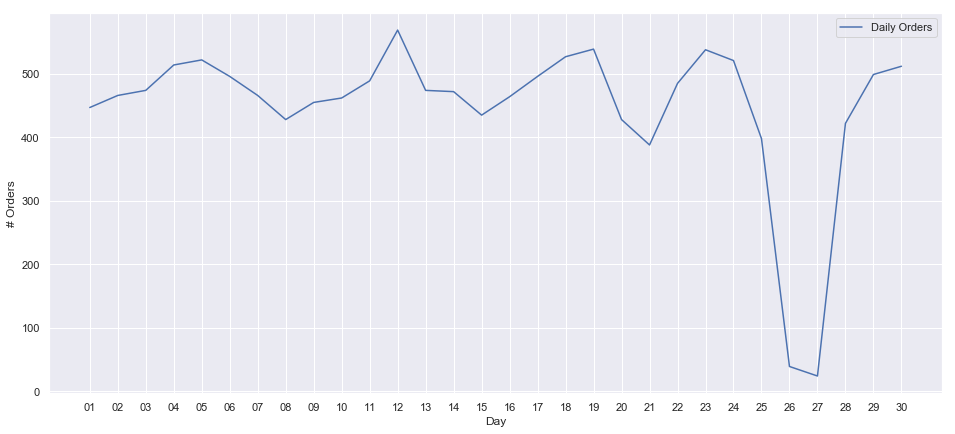

In [112]:
daily_orders = newdf.groupby('placed_order_with_restaurant_day',as_index=False).agg({'meal_of_the_day':'count'})
dims=(16,7)
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=dims)
axes.plot(daily_orders['placed_order_with_restaurant_day'],daily_orders['meal_of_the_day'],label='Daily Orders')
axes.set_xlabel("Day")
axes.set_ylabel("# Orders")
axes.legend(loc=0);

### Hourly Orders 

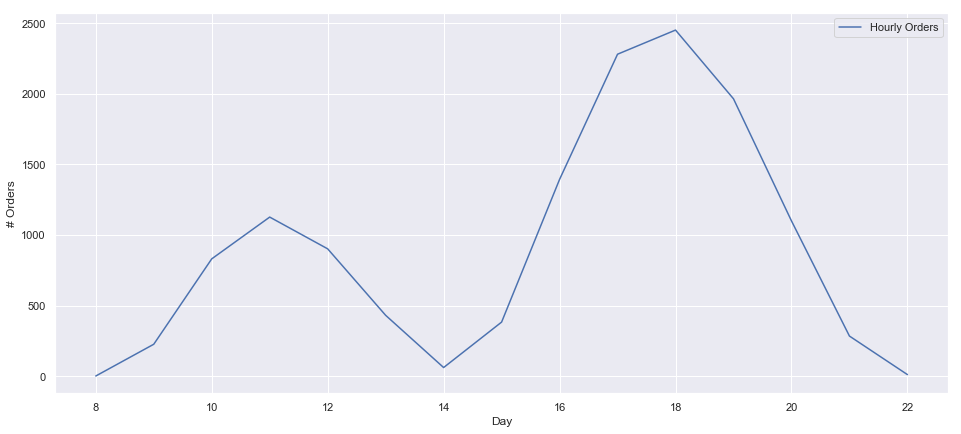

In [113]:
hourly_orders = newdf.groupby('placed_order_with_restaurant_hour',as_index=False).agg({'meal_of_the_day':'count'})
dims=(16,7)
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=dims)
axes.plot(hourly_orders['placed_order_with_restaurant_hour'],hourly_orders['meal_of_the_day'],label='Hourly Orders')
axes.set_xlabel("Day")
axes.set_ylabel("# Orders")
axes.legend(loc=0);

## Analysis in Progress

### Daily New Users vs Returning Users

>**New Users** - Users with is_new flag as true

>**Returning Users** - Users who have a prior order (is_new flag is false)

In [115]:
daily_new_users = newdf[newdf['is_new']==True].groupby('customer_placed_order_day',as_index=False).agg({'consumer_id':'count'})
daily_repeat_users = newdf[newdf['is_new']==False].groupby('customer_placed_order_day',as_index=False).agg({'consumer_id':'count'})

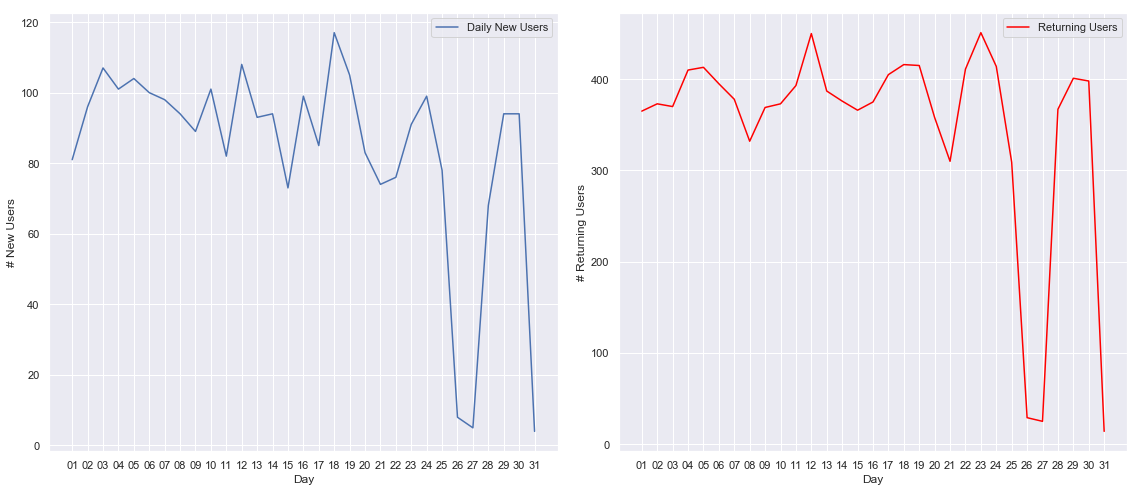

In [118]:
dims=(16,7)
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=dims)
axes[0].plot(daily_new_users['customer_placed_order_day'],daily_new_users['consumer_id'],label='Daily New Users')
axes[0].set_xlabel("Day")
axes[0].set_ylabel("# New Users")
axes[0].legend(loc=0)

axes[1].plot(daily_repeat_users['customer_placed_order_day'],daily_repeat_users['consumer_id'],label='Returning Users',color='red')
axes[1].legend(loc=0)
axes[1].set_ylabel("# Returning Users")
axes[1].set_xlabel("Day")

plt.tight_layout()

**Observation** - There is a definite drop in users at the end of the month

In [352]:
#number of first time ordering customers
new_customers = ddf.groupby(['is_new','consumer_id']).size().reset_index(name='counts')
new_customers[(new_customers['is_new']==True) & (new_customers['counts']>1)].sort_values(by='counts',ascending=False).head(5)

,is_new,consumer_id,counts
4926,True,514,12
4922,True,459,7
4961,True,929,6
5815,True,14062,6
6371,True,78977,6


**Observation:** As per **is_new** column definition, any consumer who is ordering for the first time are considered new. However, there **657** consumers who are marked new in multiple entries which makes it an anomaly. Based on the definition a consumer ordering more than once should be a returning consumer and not a new consumer 

### Is there a relationship between discounts given and returning consumer

>**Returning Consumer** - any consumer who is ordering more than 1 time is considered as returning consumer

In [272]:
#discount percentage per order

df['discount_percent'] = (df['amount_of_discount']/df['order_total'])*100
df.head()

,customer_placed_order_datetime,placed_order_with_restaurant_datetime,driver_at_restaurant_datetime,delivered_to_consumer_datetime,driver_id,restaurant_id,consumer_id,is_new,delivery_region,is_asap,order_total,amount_of_discount,amount_of_tip,refunded_amount,discount_percent
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,100.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,100.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,100.0
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,0.0
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,0.0


In [293]:
def discount_buckets(x):
    if 0<=x<1:
        return '0'
    elif 1 <= x <= 5:
        return '1-5'
    elif 5 < x <= 10:
        return '6-10'
    elif 10 < x <= 15:
        return '11-15'
    elif 15 < x <= 20:
        return '16-20'
    elif 20 < x <= 50:
        return '21-50'
    elif 50 < x <= 75:
        return '51-75'
    return '76-100'

df['discount_bucket'] = df['discount_percent'].apply(discount_buckets)

In [300]:
orders_discount_bucket = df.groupby('discount_bucket').size().reset_index(name='counts')

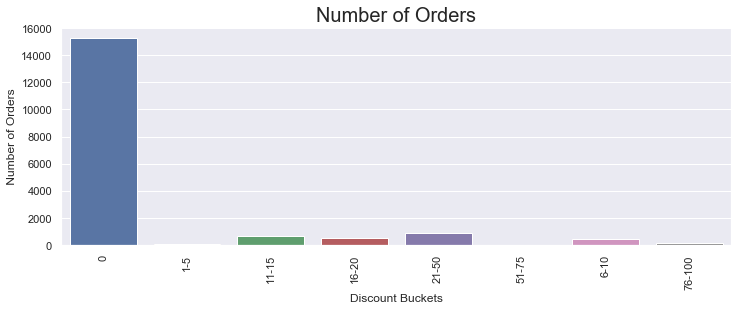

In [301]:
sns.set(style="darkgrid")
a4_dims=(12,4)
fig, ax = plt.subplots(figsize=a4_dims)
gr = sns.barplot(x="discount_bucket",y=('counts'),data=orders_discount_bucket)
gr.set_xticklabels(ax.get_xticklabels(),rotation=90);
gr.set_title("Number of Orders",fontsize=20);
ax.set(ylabel=' Number of Orders ', xlabel='Discount Buckets');

In [270]:
#calculating discount and number of orders per consumer

consumers_discount = df.groupby('consumer_id',as_index=False).agg({'amount_of_discount':'sum','order_total':'sum'}).sort_values(by='amount_of_discount',ascending=False)
temp_df = df.groupby('consumer_id').size().reset_index(name='counts')
consumers_discount['order_counts'] = temp_df['counts']
consumers_discount['discount_percentage'] = 
consumers_discount[consumers_discount['order_counts']>1].sort_values(by=['amount_of_discount','order_counts'],ascending=[False,False])

,consumer_id,amount_of_discount,order_total,order_counts
95,514,5228.59,5262.26,66
3828,36970,212.66,389.92,7
1937,7864,200.00,272.11,6
2900,12325,149.41,149.41,3
2048,8398,120.00,442.26,7
2761,11615,100.00,412.32,7
0,5,98.85,98.85,3
2641,11096,93.35,166.18,3
437,1743,87.11,87.11,3
83,475,66.71,66.71,4
